## Script responsável por realizar o tratamento dos dados e a análise descritiva

- Este código pressupõe que os arquivos do DOU estejam descompactados e se encontrem no arquivo **./saida/01_DOUSecao02_completo.parquet**
- Caso não exista o arquivo, ele pode ser gerado por meio do notebook **01_DOU_LerZips.ipynb**
- Processamento deste script:
  - Faz a leitura do arquivo **./saida/01_DOUSecao02_completo.parquet**
  - Filtra apenas portarias
  - Filtra apenas portarias do MGI
  - Cria a coluna Texto a partir da TextHTML, removento das tags html do corpo da portaria
  - Cria a coluna Total_palavras, que exibe o total de palavras da coluna Texto
  - Cria a coluna Ano com o ano da publicação (pubDate)
  - Cria a coluna Mês com o mês da publicação (pubDate)
  - Salva a saída parcial no arquivo **.\saida\02_DouSecao0<No Seção>_portarias_mgi_tratado.parquet** 
 
---


## Biblioteca

In [29]:
import pandas as pd
import string
import spacy
from bs4 import BeautifulSoup
import string
import time
import matplotlib.pyplot as plt

## 01 - Tratamento dos dados

In [2]:
# Função para contar palavras desconsiderando a pontuação
def contar_palavras(texto):
    # Remover pontuação
    texto_sem_pontuacao = texto.translate(str.maketrans('', '', string.punctuation))
    # Dividir o texto em palavras
    palavras = texto_sem_pontuacao.split()
    # Retornar a contagem de palavras
    return len(palavras)

In [3]:
# Função para extrair o texto de um texto HTML
def extract_text_from_html(html):
    soup = BeautifulSoup(html, 'html.parser')
    return soup.get_text(separator=' ')

In [4]:
douItem = 2
secao = f'Secao0{douItem}'

# Lê o arquivo Parquet
df = pd.read_parquet(f'./saida/01_DOU{secao}_completo.parquet', engine='pyarrow')  # ou engine='fastparquet'

# Exibe as primeiras linhas do DataFrame
df.shape


(497325, 27)

In [5]:
# Converte a coluna pubDate para datetime
df['pubDate'] = pd.to_datetime(df['pubDate'], errors='coerce')

# Extrair ano e mês
df.loc[:, 'Ano'] = df['pubDate'].dt.year
df.loc[:, 'Mes'] = df['pubDate'].dt.month

In [6]:
df_portaria = df[df['artType'] == 'Portaria']

df_portaria.shape

(425710, 29)

In [7]:
# Filtrar os valores que contenham "ministério da inovação" na coluna 'artCategory', ignorando case
filtro = df_portaria['artCategory'].str.contains("Ministério da Gestão e da Inovação em Serviços Público", case=False, na=False)
df_portaria_mgi = df_portaria[filtro]

# Exibir o DataFrame filtrado
df_portaria_mgi.shape

(20199, 29)

In [8]:
# Início do cronômetro
start_time = time.time()

# Garantir que estamos trabalhando com uma cópia explícita
df_portaria_mgi = df_portaria_mgi.copy()

# Cria uma coluna 'Texto' com o texto sem as tagas de HTML
df_portaria_mgi.loc[:, 'Texto'] = df_portaria_mgi['TextoHTML'].apply(extract_text_from_html)

# Cria uma coluna 'Total_palavras' com o total de palavras da coluna Texto
df_portaria_mgi.loc[:, 'Total_palavras'] = df_portaria_mgi['Texto'].apply(contar_palavras)

# Exibe o shape do DataFrame final
print(df_portaria_mgi.shape)

# Fim do cronômetro
end_time = time.time()

# Exibir o tempo de execução
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time:.2f} segundos")

(20199, 31)
Tempo de execução: 13.31 segundos


In [9]:
# Salva saída parcial o arquivo completo com novas colunas
df.to_parquet(f'./saida/02_DOU{secao}_portarias_mgi_tratado.parquet', engine='pyarrow', index=False)

In [10]:
df_portaria_mgi.head()

,id,name,idOficio,pubName,artType,pubDate,artClass,artCategory,artSize,artNotes,...,Ementa,Titulo,SubTitulo,TextoHTML,file_name,zip_name,Ano,Mes,Texto,Total_palavras
168487,30266027,PORTARIA DE PESSOAL 529,9368436,DO2,Portaria,NaT,00028:00006:00000:00000:00000:00000:00000:0000...,Ministério da Gestão e da Inovação em Serviços...,12,,...,None,None,None,"<p class=""identifica"">PORTARIA DE PESSOAL SGP/...",S02012023/529_20230125_20280233.xml.xml,S02012023.zip,NaN,NaN,"PORTARIA DE PESSOAL SGP/SEDGG/ME Nº 529, DE 17...",358
168506,30264410,ATO PORTARIA 655,9368530,DO2,Portaria,NaT,00028:00006:00000:00000:00000:00000:00000:0000...,Ministério da Gestão e da Inovação em Serviços...,12,,...,None,None,None,"<p class=""identifica"">PORTARIA SGP/SEDGG/ME Nº...",S02012023/529_20230125_20280363.xml.xml,S02012023.zip,NaN,NaN,"PORTARIA SGP/SEDGG/ME Nº 655, DE 23 DE JANEIRO...",245
168509,30265009,ATO PORTARIA DE PESSOAL 461,9368536,DO2,Portaria,NaT,00028:00006:00000:00000:00000:00000:00000:0000...,Ministério da Gestão e da Inovação em Serviços...,12,,...,None,None,None,"<p class=""identifica"">PORTARIA DE PESSOAL SGP/...",S02012023/529_20230125_20280370.xml.xml,S02012023.zip,NaN,NaN,"PORTARIA DE PESSOAL SGP/SEDGG/ME Nº 461, DE 16...",251
168510,30265678,ATO PORTARIA DE PESSOAL SGP 606,9368541,DO2,Portaria,NaT,00028:00006:00000:00000:00000:00000:00000:0000...,Ministério da Gestão e da Inovação em Serviços...,12,,...,None,None,None,"<p class=""identifica"">PORTARIA DE PESSOAL SGP/...",S02012023/529_20230125_20280375.xml.xml,S02012023.zip,NaN,NaN,"PORTARIA DE PESSOAL SGP/SEDGG/ME Nº 606, DE 19...",251
168512,30266030,ATO PORTARIA DE PESSOAL SGP 517,9368573,DO2,Portaria,NaT,00028:00006:00000:00000:00000:00000:00000:0000...,Ministério da Gestão e da Inovação em Serviços...,12,,...,None,None,None,"<p class=""identifica"">PORTARIA DE PESSOAL SGP/...",S02012023/529_20230125_20280390.xml.xml,S02012023.zip,NaN,NaN,"PORTARIA DE PESSOAL SGP/SEDGG/ME Nº 517, DE 17...",243


## 02 - Análise descritiva

In [13]:
# Verifica o total de registros por ano

# Contar registros por Ano e Mes
contagem_registros = df.groupby(['Ano']).size().reset_index(name='TotalRegistros')

# Exibir os resultados
print(contagem_registros)

# Contar registros por Ano e Mes
contagem_registros = df_portaria.groupby(['Ano']).size().reset_index(name='TotalRegistros')

# Exibir os resultados
print(contagem_registros)

# Contar registros por Ano e Mes
contagem_registros = df_portaria_mgi.groupby(['Ano']).size().reset_index(name='TotalRegistros')

# Exibir os resultados
print(contagem_registros)

      Ano  TotalRegistros
0  2022.0           66036
1  2023.0           73727
2  2024.0           63026
      Ano  TotalRegistros
0  2022.0           57371
1  2023.0           62798
2  2024.0           53963


In [15]:
import pandas as pd

# Contar total geral por Ano
total_geral = df.groupby('Ano').size().reset_index(name='TotalGeral')

# Contar total de portarias por Ano
total_portaria = df_portaria.groupby('Ano').size().reset_index(name='TotalPortaria')

# Contar total de portarias do MGI por Ano
total_portaria_mgi = df_portaria_mgi.groupby('Ano').size().reset_index(name='TotalPortariaMGI')

# Unir os resultados em um único DataFrame
resultado = total_geral.merge(total_portaria, on='Ano', how='left').merge(total_portaria_mgi, on='Ano', how='left')

# Substituir valores NaN por 0 para anos sem registros em alguma categoria
resultado.fillna(0, inplace=True)

# Garantir que as colunas estão no formato inteiro
resultado['Ano'] = resultado['Ano'].astype(int)
resultado[['TotalGeral', 'TotalPortaria', 'TotalPortariaMGI']] = resultado[['TotalGeral', 'TotalPortaria', 'TotalPortariaMGI']].astype(int)

# Exibir o resultado final
resultado.head()

,Ano,TotalGeral,TotalPortaria,TotalPortariaMGI
0,2022,66036,57371,0
1,2023,73727,62798,3952
2,2024,63026,53963,3658


In [27]:
# Verifica as portarias publicadas considrando Ministério da Economia e MGI

# Filtrar registros com artType = "Portaria"
filtro_portaria = df['artType'].str.lower() == "portaria"

# Filtrar registros do ano de 2023
filtro_ano = df['Ano'] == 2023

# Verificar registros com "Ministério da Economia" em artCategory, ignorando case
filtro_economia = df['artCategory'].str.contains("Ministério da Economia", case=False, na=False)

# Verificar registros com "Ministério da Gestão e da Inovação" em artCategory, ignorando case
filtro_gestao = df['artCategory'].str.contains("Ministério da Gestão e da Inovação", case=False, na=False)

# Combinar os filtros para cada categoria no ano de 2023 e com artType = "Portaria"
filtro_economia_2023 = filtro_portaria & filtro_ano & filtro_economia
filtro_gestao_2023 = filtro_portaria & filtro_ano & filtro_gestao

# Quantidade de registros com "Ministério da Economia" em 2023
qtde_economia_2023 = df.loc[filtro_economia_2023].shape[0]

# Quantidade de registros com "Ministério da Gestão e da Inovação" em 2023
qtde_gestao_2023 = df.loc[filtro_gestao_2023].shape[0]

# Quantidade total de registros de "Portaria" em 2023
qtde_total_2023 = df.loc[filtro_portaria & filtro_ano].shape[0]

# Exibir os resultados
print(f"Quantidade de registros de 'Portaria' com 'Ministério da Economia' em 2023: {qtde_economia_2023}")
print(f"Quantidade de registros de 'Portaria' com 'Ministério da Gestão e da Inovação' em 2023: {qtde_gestao_2023}")
print(f"Quantidade total de registros de 'Portaria' em 2023: {qtde_total_2023}")


Quantidade de registros de 'Portaria' com 'Ministério da Economia' em 2023: 592
Quantidade de registros de 'Portaria' com 'Ministério da Gestão e da Inovação' em 2023: 3952
Quantidade total de registros de 'Portaria' em 2023: 62798


In [28]:
# Análise descritiva na qtde de palavras da coluna Texto

# Garantir que a coluna Total_palavras seja numérica
df_portaria_mgi['Total_palavras'] = pd.to_numeric(df_portaria_mgi['Total_palavras'], errors='coerce')

# Calcular as estatísticas
menor_qtde = df_portaria_mgi['Total_palavras'].min()
media = df_portaria_mgi['Total_palavras'].mean()
mediana = df_portaria_mgi['Total_palavras'].median()
maximo = df_portaria_mgi['Total_palavras'].max()

# Exibir os resultados
print(f"Menor quantidade de palavras: {menor_qtde}")
print(f"Média de palavras: {media}")
print(f"Mediana de palavras: {mediana}")
print(f"Maior quantidade de palavras: {maximo}")


Menor quantidade de palavras: 25
Média de palavras: 212.81236694885885
Mediana de palavras: 169.0
Maior quantidade de palavras: 11473


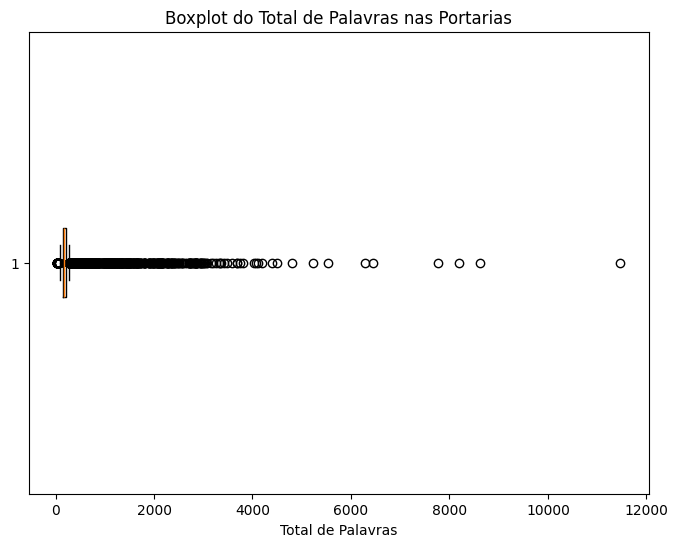

In [30]:
# Garantir que a coluna Total_palavras seja numérica
df_portaria_mgi['Total_palavras'] = pd.to_numeric(df_portaria_mgi['Total_palavras'], errors='coerce')

# Criar o boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(df_portaria_mgi['Total_palavras'].dropna(), vert=False)
plt.title('Boxplot do Total de Palavras nas Portarias')
plt.xlabel('Total de Palavras')
plt.show()


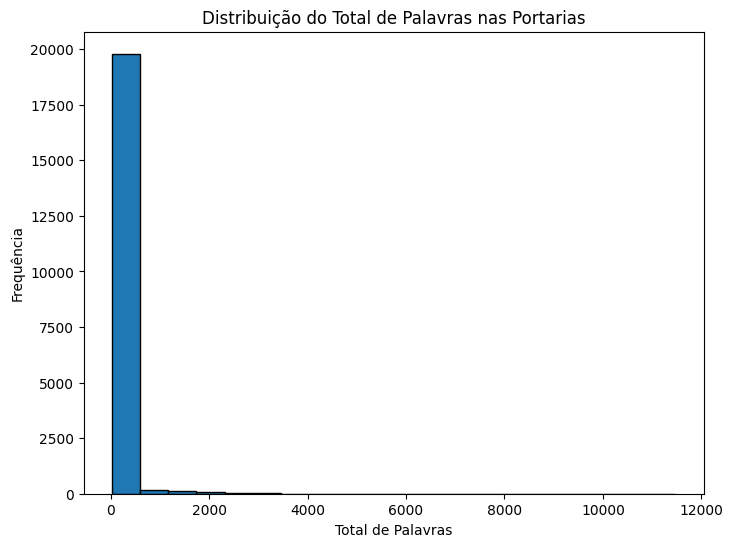

In [31]:
# Criar o histograma
plt.figure(figsize=(8, 6))
plt.hist(df_portaria_mgi['Total_palavras'].dropna(), bins=20, edgecolor='black')
plt.title('Distribuição do Total de Palavras nas Portarias')
plt.xlabel('Total de Palavras')
plt.ylabel('Frequência')
plt.show()